In [2]:
import os
import time
import pandas as pd
import numpy as np
import numpy.random as npr
import copy
import re
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
from scipy.special import digamma, loggamma

In [12]:
def clean_text(text):
    with open("vocab.txt", "r") as file:
        vocab = [line.strip() for line in file.readlines()]
    vocab_set = set(vocab)
    contractions = {
        r"n\'t": 'nt',
        r"\'s": 's',     
        r"\'ve": 've',   
        r"\'re": 're',   
        r"\'m": 'm',     
        r"\'ll": 'll',   
        r"\'d": 'd'      
    }

    text = text.lower().strip()
    text = re.sub(r'[.,!?;:"``]', " ", text)
    words = []
    for word in text.split():
        if "'" in word:
            word_added = False
            for pattern, replacement in contractions.items():
                if word.endswith(pattern):
                    contracted = word.replace(pattern, replacement)
                    if contracted in vocab_set:
                        words.append(contracted)
                        word_added = True
                        break
            
            if not word_added:
                combined = word.replace("'", "")
                if combined in vocab_set:
                    words.append(combined)

        if "-" in word:
            combined = word.replace("-", "")
            if combined in vocab_set:
                words.append(combined)
                continue
                
            parts = [p for p in word.split("-") if p in vocab_set]
            words.extend(parts)
        else:
            if word in vocab_set:
                words.append(word)
    return words

def create_BoW_representation(doc_words, vocab_dict):
    word_counts = Counter(word for word in doc_words if word in vocab_dict)
    BoW_entries = []
    for word, count in word_counts.items():
        word_idx = vocab_dict[word]
        BoW_entries.append(f"{word_idx}:{count}")
    BoW_entries.sort(key=lambda x: int(x.split(":")[0]))

    return f"{len(BoW_entries)} {" ".join(BoW_entries)}"

def process_documents(input_file, vocab_file):
    with open(vocab_file, "r") as file:
        vocab = [line.strip() for line in file.readlines()]
    vocab_dict = {word: idx for idx, word in enumerate(vocab)}

    with open(input_file, "r") as file:
        raw_text = file.read()

    documents = re.findall(r"<TEXT>\n(.*?)\n </TEXT", raw_text, re.DOTALL)
    BoW_representations = []
    for doc in tqdm(documents):
        words = clean_text(doc)
        BoW = create_BoW_representation(words, vocab_dict)
        BoW_representations.append(BoW)

    return BoW_representations

def log_sum_exp(vec):
    vec_max = np.max(vec, axis=0)
    exp_vec = np.exp(vec - vec_max)
    sum_exp_vec = np.sum(exp_vec)
    log_sum_exp = np.log(sum_exp_vec) + vec_max
    return log_sum_exp

In [14]:
AP_BoW = process_documents("ap.txt", "vocab.txt")

with open("AP_BoW.txt", "w") as file:
    file.write('\n'.join(AP_BoW))

100%|██████████| 2246/2246 [00:05<00:00, 400.37it/s]


In [17]:
def load_documents():
    with open("vocab.txt", "r") as file:
        raw_lines = file.readlines()
    idx_to_words = [word.strip() for word in raw_lines]
    V = len(idx_to_words)

    with open("ap_bow.txt", "r") as file:
        raw_lines = file.readlines()
        N = len(raw_lines)
    documents = np.zeros((N, V))
    nonzero_idxs = []

    for i in tqdm(range(N)):
        BoW_doc = raw_lines[i].split(" ")
        M = int(BoW_doc[0])
        BoW_doc = BoW_doc[1:]
        document = np.zeros((V,))
        nonzero_idx = []
        for BoW in BoW_doc:
            BoW = BoW.strip()
            word_idx, count = BoW.split(":")
            nonzero_idx.append(int(word_idx))
            document[int(word_idx)] = count
        assert(len(nonzero_idx) == M)

        documents[i] = document
        nonzero_idxs.append(sorted(nonzero_idx))
    
    return idx_to_words, documents, nonzero_idxs

def init_variational_params(documents, K):
    N, V = documents.shape
    LAMBDA = np.random.uniform(low=0.01, high=1.0, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = []
    for document in documents:
        M = np.sum((document > 0).astype("int32"))
        document_PHI = np.ones((M, K))
        document_PHI = document_PHI / K
        PHI.append(document_PHI)

    return LAMBDA, GAMMA, PHI

idx_to_words, documents, nonzero_idxs = load_documents()
K = 30
V = len(idx_to_words)
ETA = 100 / V
ALPHA = 1 / K

100%|██████████| 2246/2246 [00:00<00:00, 7022.12it/s]


In [98]:
LAMBDA, GAMMA, PHI = init_variational_params(documents, K)

In [ ]:
def compute_ELBO(LAMBDA, GAMMA, PHI, documents, nonzero_idxs, K):
    ELBO = 0
    N, _ = documents.shape

    E_log_p_BETA = np.sum((ETA-1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))))
    ELBO += E_log_p_BETA

    E_log_p_THETA = np.sum((ALPHA-1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))))
    ELBO += E_log_p_THETA

    E_log_p_x_z = 0
    for i in range(N):
        document = documents[i]
        nonzero_idx = nonzero_idxs[i]
        word_idx = 0
        for idx in nonzero_idx:
            E_log_p_x_z += document[idx] * np.sum(PHI[i][word_idx] * (digamma(GAMMA[i])-digamma(np.sum(GAMMA[i])))) \
                + document[idx] * np.sum(PHI[i][word_idx] * (digamma(LAMBDA[:, idx])-digamma(np.sum(LAMBDA, axis=1))))
            word_idx += 1
    ELBO += E_log_p_x_z

    E_log_q_BETA = np.sum(-loggamma(np.sum(LAMBDA, axis=1)) + np.sum(loggamma(LAMBDA), axis=1) \
        - np.sum((LAMBDA - 1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))), axis=1))
    ELBO += E_log_q_BETA

    E_log_q_THETA = np.sum(-loggamma(np.sum(GAMMA, axis=1)) + np.sum(loggamma(GAMMA), axis=1) \
        - np.sum((GAMMA - 1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))), axis=1))
    ELBO += E_log_q_THETA

    E_log_q_z = 0
    for i in range(N):
        document = documents[i]
        nonzero_idx = nonzero_idxs[i]
        word_idx = 0
        for idx in nonzero_idx:
            E_log_q_z += -document[idx] * np.sum(PHI[i][word_idx] * np.log(PHI[i][word_idx]))
            word_idx += 1
    ELBO += E_log_q_z

    return ELBO

In [ ]:
LAMBDA_t = copy.deepcopy(LAMBDA)
GAMMA_t = copy.deepcopy(GAMMA)
PHI_t = copy.deepcopy(PHI)

N, V = documents.shape
ELBOs = []
for i in tqdm(range(N), desc="Updating PHI and GAMMA"):
    document = documents[i]
    nonzero_idx = nonzero_idxs[i]
    GAMMA_i_t = copy.deepcopy(GAMMA_t[i])
    word_idx = 0
    for idx in nonzero_idx:
        log_PHI_ij = np.zeros((K,))
        for k in range(K):
            LAMBDA_k_t = copy.deepcopy(LAMBDA_t[k])
            exp_propto = digamma(GAMMA_i_t[k]) - digamma(np.sum(GAMMA_i_t)) + digamma(LAMBDA_k_t[idx]) - digamma(np.sum(LAMBDA_k_t))
            log_PHI_ij[k] = exp_propto
        PHI_ij = np.exp(log_PHI_ij - log_sum_exp(log_PHI_ij))
        PHI_t[i][word_idx] = PHI_ij
        word_idx += 1
    GAMMA_i_t = np.zeros((K,)) + ALPHA
    for k in range(K):
        GAMMA_i_t[k] += np.sum(document[nonzero_idx] * PHI_t[i][:, k])
    GAMMA_t[i] = GAMMA_i_t

100%|██████████| 2246/2246 [04:59<00:00,  7.51it/s]


In [ ]:
for k in tqdm(range(K), desc="Updating LAMBDA"):
    LAMBDA_k_t = np.zeros((V,)) + ETA
    for i in range(N):
        document = documents[i]
        nonzero_idx = nonzero_idxs[i]
        word_idx = 0
        for idx in nonzero_idx:
            LAMBDA_k_t[idx] += document[idx] * PHI_t[i][word_idx][k]
            word_idx += 1
        LAMBDA_t[k] = LAMBDA_k_t

compute_ELBO(LAMBDA_t, GAMMA_t, PHI_t, articles, nonzero_idxs, K)

100%|██████████| 30/30 [00:11<00:00,  2.53it/s]


np.float64(-2860507.912042409)

In [138]:
stop_words = set(stopwords.words("english"))
with open("vocab.txt", "r") as file:
    raw_lines = file.readlines()
vocab = [word.strip() for word in raw_lines if word not in stop_words]
len(vocab), len(raw_lines)

(10473, 10473)

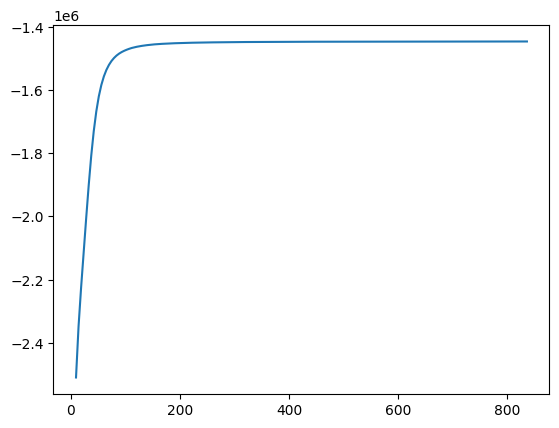

In [124]:
df = pd.read_csv("ELBO_V_10000.csv")
plt.plot(df["time_iter"][2:] / 60, df["ELBO"][2:])